## this script is based on the W1D4 tutorial 2 logistic regression decoder

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import hashlib
import pickle
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
#Helper functions taken from the tutorial

def plot_weights(models, sharey=True):
    """Draw a stem plot of weights for each model in models dict."""
    n = len(models)
    f = plt.figure(figsize=(10, 2.5 * n))
    axs = f.subplots(n, sharex=True, sharey=sharey)
    axs = np.atleast_1d(axs)
    for ax, (title, model) in zip(axs, models.items()):
        ax.margins(x=.02)
        stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
        stem[0].set_marker(".")
        stem[0].set_color(".2")
        stem[1].set_linewidths(.5)
        stem[1].set_color(".2")
        stem[2].set_visible(False)
        ax.axhline(0, color="C3", lw=3)
        ax.set(ylabel="Weight", title=title)
    ax.set(xlabel="Neuron (a.k.a. feature)")
    f.tight_layout()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )

def plot_model_selection(C_values, accuracies):
    """Plot the accuracy curve over log-spaced C values."""
    ax = plt.figure().subplots()
    ax.set_xscale("log")
    ax.plot(C_values, accuracies, marker="o")
    best_C = C_values[np.argmax(accuracies)]
    ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
    )

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
    """Plot the accuracy curve over log-spaced C values."""
    ax = plt.figure().subplots()
    ax.set_xscale("log")
    ax.plot(C_values, non_zero_l1, marker="o")
    ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
    )
    ax.axhline(n_voxels, color=".1", linestyle=":")
    ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")

def sigmoid(z):
    return 1 / (1+np.exp(-z))

# download the steinmetz dataset used in the tutorial

In [4]:
url = "https://osf.io/r9gh8/download"
fname = "W1D4_steinmetz_data.npz"
expected_md5 = "d19716354fed0981267456b80db07ea8"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)


In [5]:
def load_steinmetz_data(data_fname=fname):
    with np.load(data_fname) as dobj:
        data = dict(**dobj)
    return data

# Load data

In [6]:
#this is sample data provided in tutorial
data = load_steinmetz_data()
for key, val in data.items():
    print(key, val.shape)

spikes (276, 691)
choices (276,)


In [149]:
trials_df = pd.read_pickle('trials_df.p')
trials_df[6:11]

,included,repetition number,start time,stim time,response time,feedback time,end time,stim contrast left,stim contrast right,response choice,feedback type,wheel event types,wheel event onset times,wheel event offset times,wheel movement,premove spikerates,postmove spikerates
6,True,1,80.568255,83.025043,84.046862,84.046862,85.055605,0,0,-1,-1,"[0.0, 0.0, 0.0, 2.0]","[80.69151886704108, 81.25251886704109, 81.5825...","[80.97751886704108, 81.3145188670411, 81.70351...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 20.0..."
7,True,2,86.052635,87.630693,90.192086,90.225191,91.195968,0,0,0,1,"[0.0, 0.0, 0.0]","[87.14851886704109, 88.37751886704109, 90.2535...","[87.2175188670411, 88.56251886704109, 93.69851...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0,...","[10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 10.0..."
8,True,1,92.193720,94.285251,95.312875,95.350478,96.318125,0,0,-1,1,[2.0],[94.50251886704109],[97.2605188670411],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 5.0,...","[0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 5.0, 0.0, 15.0,..."
9,True,1,97.318724,97.825311,98.962657,99.000541,99.968993,0,1,-1,1,"[2.0, 0.0]","[98.20951886704108, 99.7175188670411]","[99.4275188670411, 99.90551886704108]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 0.0, 10.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 20.0..."
10,True,1,100.964011,101.540425,102.228879,102.264597,103.236802,1,0,1,1,[1.0],[101.80551886704109],[104.3815188670411],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 35.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 10.0..."


In [162]:
#here we select the trials

right_go_corr = (trials_df['stim contrast right'] > trials_df['stim contrast left']) & (trials_df['response choice'] == -1)
left_go_corr = (trials_df['stim contrast right'] < trials_df['stim contrast left']) & (trials_df['response choice'] == 1)
all_go_corr = right_go_corr | left_go_corr
print(np.sum(all_go_corr))

all_nogo_corr = (trials_df['stim contrast right'] == 0) & (trials_df['stim contrast left'] == 0) & (trials_df['response choice'] == 0)
print(np.sum(all_nogo_corr))

all_corr = all_go_corr | all_nogo_corr
all_corr = all_used
print(np.sum(all_used))

all_FA = (trials_df['stim contrast right'] == 0) & (trials_df['stim contrast left'] == 0) & (trials_df['response choice'] != 0)
print(np.sum(all_FA))

50
99
149
62


In [163]:
len(np.where(all_used)[0])

149

In [164]:
#make CORRECT CHOICE arrays with spike rates and choices per trial
rates_df = trials_df['premove spikerates']
spikes = np.zeros((len(np.where(all_used)[0]),len(rates_df[0])))
choices = np.zeros(len(np.where(all_used)[0]))
for i,itrial in enumerate(np.where(all_used)[0]):
    spikes[i,:] = rates_df[itrial]
    if all_go_corr[itrial]:
        choices[i] = 1
    else:
        choices[i] = 0 
spikes = np.nan_to_num(spikes)
print(spikes.shape)
print(choices.shape)

(149, 1627)
(149,)


In [165]:
#these values are used to train our model
y = choices
X = spikes

In [166]:
#make FALSE ALARM arrays with spike rates and choices per trial
spikes = np.zeros((len(np.where(all_FA)[0]),len(rates_df[0])))
choices = np.zeros(len(np.where(all_FA)[0]))
for i,itrial in enumerate(np.where(all_FA)[0]):
    spikes[i,:] = rates_df[itrial]
    if all_FA[itrial]:
        choices[i] = 1
spikes = np.nan_to_num(spikes)
print(spikes.shape)
print(choices.shape)

(62, 1627)
(62,)


In [167]:
#these values are used to test what the decoder says
y_test = choices
X_test = spikes

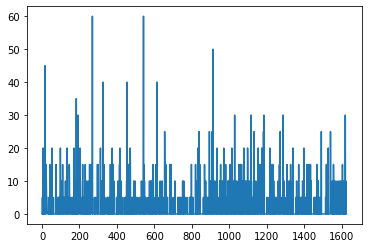

In [168]:
plt.figure
plt.plot(X[0,:])

# fit logistic regression models

In [169]:
# First define the model
log_reg = LogisticRegression(penalty='none',solver='newton-cg')

#Then fit it to data
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [170]:
#get accuracy of the model on the training set (should be high!)
y_pred = log_reg.predict(X)
train_accuracy = np.mean(y_pred == y)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


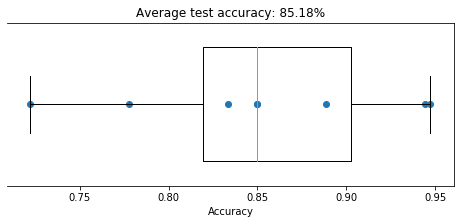

In [173]:
#get accuracy of a l2-regularized model on a k-fold cross validated set

k=8 #choose k-fold
reg = 'l2' #choose regularization. 'none', 'l1', or 'l2'
lam = 1 #choose lambda for regularizer

#fit model
#log_reg = LogisticRegression(penalty='none').fit(X, y)
log_reg = LogisticRegression(penalty=reg, C=1/lam, solver='lbfgs', max_iter=2000).fit(X, y)

#get cross-validated accuracies
accuracies = cross_val_score(log_reg, X, y, cv=k)

#plot the resulting accuracies
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones_like(accuracies))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

Percentage of FA trials on which the model predicts POSITIVE RESPONSE: 54.84%


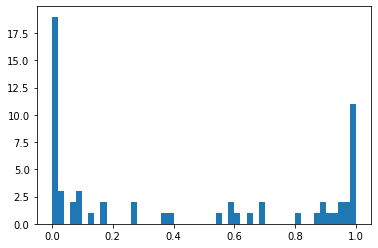

In [174]:
y_test_pred = log_reg.predict(X_test)
y_test_proba = log_reg.predict_proba(X_test)
y_test_acc = log_reg.score(X_test,y_test)

print(f"Percentage of FA trials on which the model predicts POSITIVE RESPONSE: {y_test_acc:.2%}")

plt.figure(figsize=(6,4))
plt.hist(y_test_proba[:,],bins=50)
plt.show()

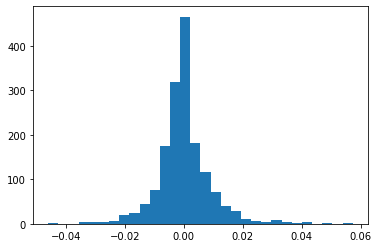

In [120]:
plt.figure(figsize=(6,4))
plt.hist(log_reg.coef_[0],bins=30)
plt.show()


In [ ]:
all_FA

In [90]:
def model_selection(X, y, C_values, CV_values):
    """Compute CV accuracy for each C value.

    Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values

    Returns:
    accuracies (1D array): CV accuracy with each value of C

    """
    accuracies_all = []

    for CV in CV_values:

        accuracies = []

        for C in C_values:

            # Initialize and fit the model
            model = LogisticRegression(penalty='l2',C=C, solver='lbfgs',max_iter=2000)
            model.fit(X,y)

            # Get the accuracy for each test split
            accs = cross_val_score(model,X,y,cv=int(CV))

            # Store the average test accuracy for this value of C
            accuracies.append(np.mean(accs))

        accuracies_all.append(accuracies)

    return accuracies_all



# Use log-spaced values for C and CV

C_values = np.logspace(-4, 4, 9)

#CV_values = np.linspace(2,20,10)
CV_values = np.logspace(1,5,5,base=2)
#CV_values = np.logspace(np.arange(2,50,2)

accuracies_all = model_selection(X, y, C_values, CV_values)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 50 members, which is too few. The minimum number of members in any class cannot be less than n_splits=64.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 50 members, which is too few. The minimum number of members in any class cannot be less than n_splits=64.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 50 members, which is too few. The minimum number of members in any class cannot be less than n_splits=64.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 50 members, which is too few.

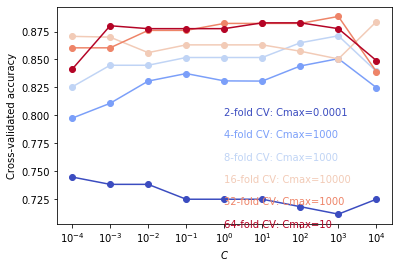

In [91]:
#plot results
ax = plt.figure().subplots()
ax.set_xscale("log")
cmap = plt.cm.get_cmap('coolwarm')
for i,accuracies in enumerate(accuracies_all):
    c = cmap(i/(len(accuracies_all)-1))
    ax.plot(C_values, accuracies, marker="o",color=c)
    best_C = C_values[np.argmax(accuracies)]
    plt.text(1,0.8-0.02*i,f"{CV_values[i]:1g}-fold CV: Cmax={best_C:1g}",color=c)
ax.set(
  xticks=C_values,
  xlabel="$C$",
  ylabel="Cross-validated accuracy",
)
plt.show()